In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, UperNetForSemanticSegmentation

from src.utils.io import load_image, load_mask

image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-tiny")
model = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-tiny")

model.decode_head.classifier = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))

In [23]:
tens = torch.rand(2, 3, 400, 400)

out = model(tens)

out.logits.shape

torch.Size([2, 1, 400, 400])

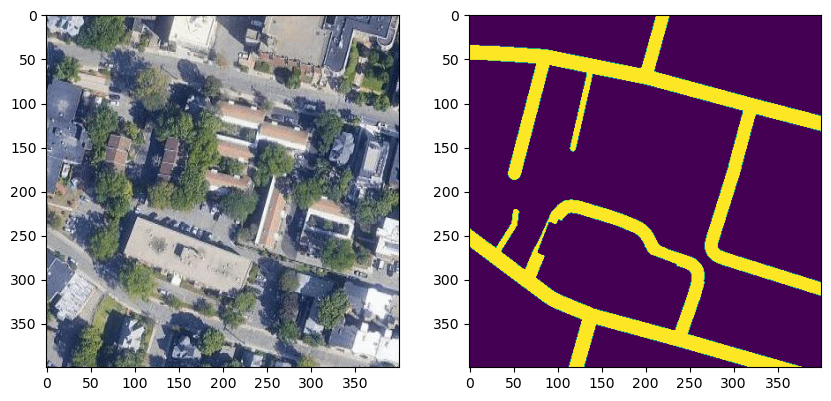

In [24]:
img = load_image("../data/processed/validation/images/000000001_cil.jpg") * 255
mask = load_mask("../data/processed/validation/masks/000000001_cil.png")

img = img.astype("uint8")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()

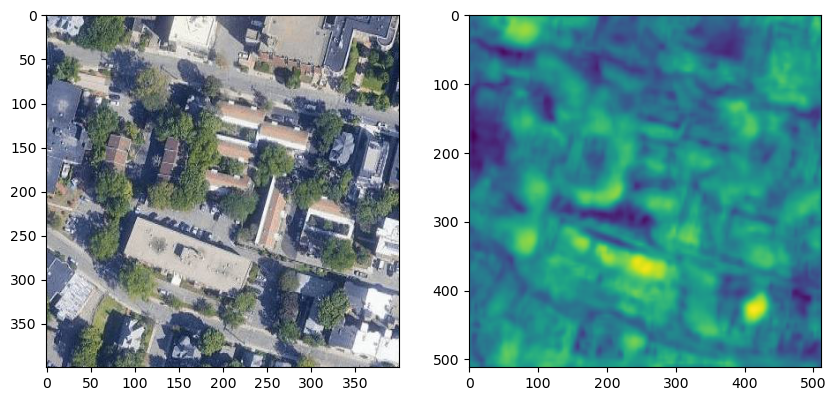

In [25]:
img_processed = image_processor(images=img, return_tensors="pt")
out = model(**img_processed)

pred = out.logits.squeeze().detach().sigmoid().numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(pred)
plt.show()

# Train on single image

In [26]:
n_params_backbone = sum(p.numel() for p in model.backbone.parameters() if p.requires_grad)
n_params_head = sum(p.numel() for p in model.decode_head.parameters() if p.requires_grad)

print(f"Number of parameters in backbone: {n_params_backbone / 1e6:.2f} M")
print(f"Number of parameters in head: {n_params_head / 1e6:.2f} M")

Number of parameters in backbone: 196.23 M
Number of parameters in head: 36.88 M


In [27]:
# freeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = False


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = torch.nn.BCELoss()

n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"#params: {n_params / 1e6:.2f} M")

#params: 38.69 M


In [28]:
img_processed = image_processor(images=[img, img], return_tensors="pt")
img_processed.pixel_values.shape

torch.Size([2, 3, 512, 512])

In [29]:
scale = 512 / max(img.shape)
mask = Image.fromarray(mask)
mask = mask.resize((int(mask.width * scale), int(mask.height * scale)), Image.NEAREST)
mask = np.array(mask)

gt_tens = torch.tensor(mask)
gt_tens = torch.stack([gt_tens, gt_tens]).float()
gt_tens.shape

torch.Size([2, 512, 512])

Training:   0%|                              | 0/50 [00:04<?, ?it/s, loss=0.371]

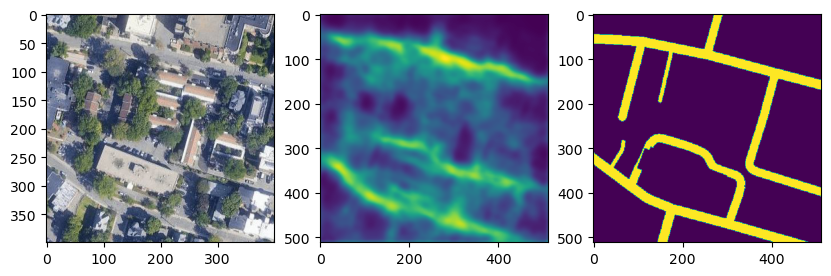

Training:  20%|████▏                | 10/50 [00:46<02:45,  4.13s/it, loss=0.316]

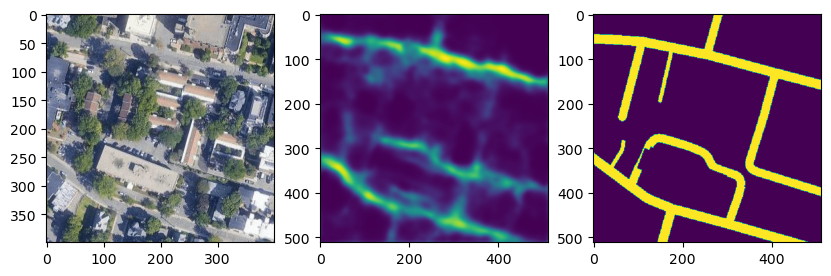

Training:  40%|████████▍            | 20/50 [01:29<02:02,  4.07s/it, loss=0.215]

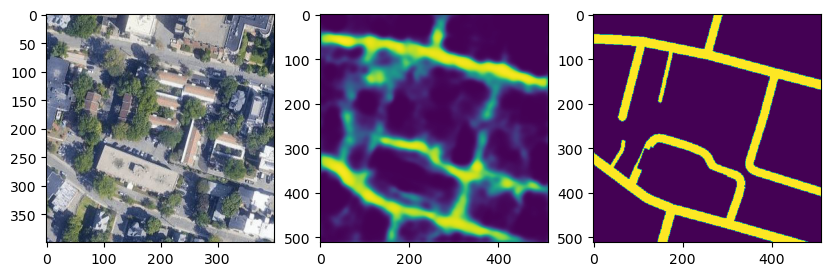

Training:  60%|████████████▌        | 30/50 [02:12<01:23,  4.20s/it, loss=0.166]

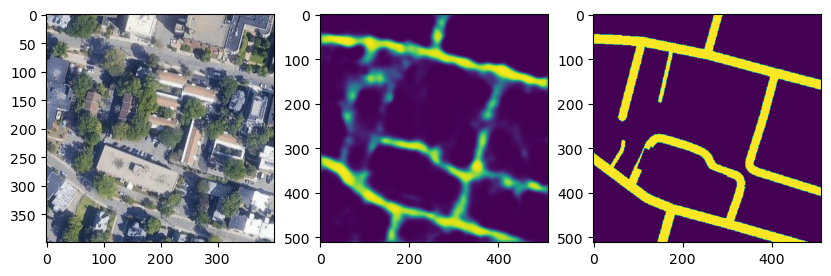

Training:  80%|████████████████▊    | 40/50 [02:54<00:40,  4.00s/it, loss=0.127]

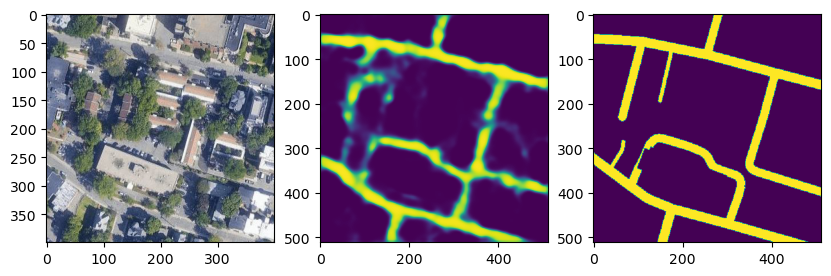

Training: 100%|█████████████████████| 50/50 [03:30<00:00,  4.22s/it, loss=0.103]


In [14]:
from tqdm import tqdm

pbar = tqdm(range(50), desc="Training", ncols=80)

for epoch in pbar:
    optimizer.zero_grad()
    out = model(**img_processed).logits.sigmoid().squeeze(1)
    loss = criterion(out, gt_tens)
    loss.backward()
    optimizer.step()
    pbar.set_postfix({"loss": loss.item()})

    if epoch % 10 == 0:
        img_plot = image_processor(images=img, return_tensors="pt")
        o = model(**img_plot)

        p = o.logits.squeeze().detach().sigmoid().numpy()

        fig, ax = plt.subplots(1, 3, figsize=(10, 5))
        ax[0].imshow(img)
        ax[1].imshow(p)
        ax[2].imshow(mask)
        plt.show()

pbar.close()

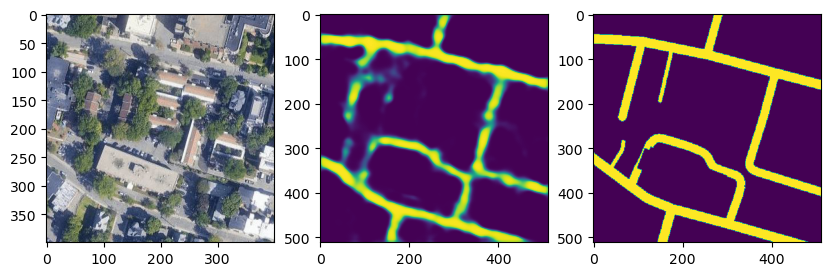

In [15]:
img_plot = image_processor(images=img, return_tensors="pt")
o = model(**img_plot)

p = o.logits.squeeze().detach().sigmoid().numpy()

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img)
ax[1].imshow(p)
ax[2].imshow(mask)
plt.show()